                             OLS Regression Results                             
Dep. Variable:     xoms.overall_seconds   R-squared:                       0.947
Model:                              OLS   Adj. R-squared:                  0.947
Method:                   Least Squares   F-statistic:                 1.064e+04
Date:                  Mon, 29 Apr 2024   Prob (F-statistic):               0.00
Time:                          15:09:15   Log-Likelihood:                -12671.
No. Observations:                  1799   AIC:                         2.535e+04
Df Residuals:                      1795   BIC:                         2.537e+04
Df Model:                             3                                         
Covariance Type:              nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const       

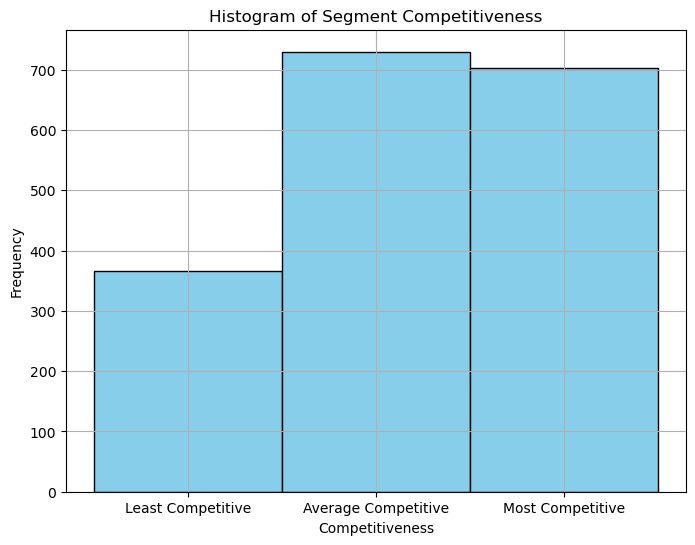

In [2]:
#this process will answer these questions:
# which segments are the most competitive in terms of how fast their record time is?
# can we find out which segments might have a relatively slow record time that could be more easily broken?
#
#
#simple linear regression to predict which segments may have 
#the most overly competetive record times and underly competetive record times
#
# e.g.
#    if the model predicts a record time that is quicker than what is currently recorded as the record,
#    then this indicates that it may be easier to go faster than the current record time, 
#          based on segment attributes that were used as regressors to the model
#
#    if the model predicts a record time that is longer than the real current record, 
#    then this indicates that it may be more difficult to go faster than the current record time

import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

#load the data
data = pd.read_csv('strava.csv')

# choose inputs and output
# feel free to use more inputs, or create new inputs - interaction terms etc. Experiment
x = data[['distance', 'average_grade', 'total_elevation_gain' ]]
y = data['xoms.overall_seconds']   
x_and_const = sm.add_constant(x)
#print(x_and_const.head(100))


# Step 4: Train the model
model = sm.OLS(y, x_and_const)  # Add a constant term to the features for linear regression
result = model.fit()
print(result.summary())

y_pred = result.predict(x_and_const)

#if the predicted number of seconds is greater than actual number of seconds -> positive difference
#  positive difference -> the record is even faster than the model would predict -> more competitive
#differences = y_pred - y

#create a new column in the data to represent this.
# if the predicted time is more than 30 seconds slower(bigger) than the predicted time fill in 1 for competitive
# if the predicted time is more than 30 seconds faster(smaller)than the predicted time fill in -1 for competitive
# else 0, for neither very competitive nor not competitive
data['competitive'] = pd.Series(np.where(y_pred > y+30, 1, np.where(y_pred < y-30, -1, 0)))
#data['competitive'] = pd.Series(pd.np.where(differences > 30, 1, pd.np.where(differences < -30, -1, 0)))
#print(data)

# We can use output columns like 'competitiveness' to do data visualization
#   for example, we could use a geographic mapping package to create a map of the Boise area
#   where we plot all of the routes (using there polyline) that are the most competitive in RED
#                                         ''                           least competitive in GREEN
#                        ''                                                 other routes in BLUE


#plot the distribution of segment competitiveness
plt.figure(figsize=(8, 6))
plt.hist(data.competitive, bins=[-1.5, -0.5, 0.5, 1.5], color='skyblue', edgecolor='black')
plt.xlabel('Competitiveness')
plt.ylabel('Frequency')
plt.title('Histogram of Segment Competitiveness')
plt.xticks([-1, 0, 1], ['Least Competitive', 'Average Competitive', 'Most Competitive'])
plt.grid(True)
plt.show()

# save the new data that includes a column competitiveness
data.to_csv('strava_comp.csv', index=False)


In [3]:
#generate a KML file for viewing results on google earth
# We can use output column 'competitiveness' to do data visualization
#   where we plot all of the routes (using their polyline) that are the most competitive in RED
#                                         ''                           least competitive in YELLOW
#                        ''                                  other (intermediate) routes in ORANGE

import simplekml
import polyline
import csv

def create_kml(csv_file, output_kml, columns_mapping):
    kml = simplekml.Kml()
    
    with open(csv_file, 'r') as file:
        reader = csv.DictReader(file)
        for row in reader:
            name = row['name']
            polyline_str = row['map.polyline']
            comp = int(row['competitive'])
            
            #extract additional columns for the description
            additional_info = ""
            for key, display_name in columns_mapping.items():
                if key == 'id':  # Check if the column is 'More info' to add a link to route id to make url
                    additional_info += f"<tr><td>{display_name}</td><td>https://www.strava.com/segments/{row[key]}</td></tr>"
                else:
                    additional_info += f"<tr><td>{display_name}</td><td>{row[key]}</td></tr>"
            
            coordinates = polyline.decode(polyline_str, geojson=True)
            
            lin = kml.newlinestring(name=name, coords=coordinates)
            lin.description = f"<table border='1'><tr></tr>{additional_info}</table>"

            lin.style.linestyle.width = 2  # Adjust the value as needed
            if comp == -1:
                lin.style.linestyle.color = simplekml.Color.yellow
            elif comp == 0:
                lin.style.linestyle.color = simplekml.Color.orange
            else:
                lin.style.linestyle.color = simplekml.Color.red
    
    kml.save(output_kml)

columns_mapping = {'total_elevation_gain': 'Elevation Gain (m)',
                  'xoms.overall':'Fastest Time (H:MM:SS)', 'athlete_count':'# Athletes that have completed'
                  ,'id':'More info'}  # Specify the columns and their display names
create_kml('strava_comp.csv', 'output_final.kml', columns_mapping)